# Build offshore wind suitablity layers for GRIDCERF


The following code was used to build the offshore wind suitability layers for GRIDCERF. GRIDCERF does not provide the source data directly due to some license restrictions related for direct redistribution of the unaltered source data.  However, the following details the provenance associated with each source dataset and how they were processed.

## 1. Setup environment

### 1.1 Download GRIDCERF

Download the GRIDCERF package if you have not yet done so from here:  https://doi.org/10.5281/zenodo.6601789.  Please extract GRIDCERF inside the `data` directory of this repository as the paths in this notebook are set to that expectation.


### 1.2 Data description


- **Title**:  National Marine Sanctuary Program Digital Boundary Files
- **Description from Source**: The Office of National Marine Sanctuaries manages a system of sanctuaries and other managed areas around the country. The legal boundaries of these sanctuaries are defined within the Code of Federal Regulations, at 15 C.F.R. Part 922 and the subparts for each national marine sanctuary. The GIS compatible digital boundary files for each national marine sanctuary are representations of those legal boundaries and are based on the best available data. These files are available for public use at locations defined in this metadata record.
- **Boundaries Included**: Channel Islands, Cordell Bank, Florida Keys, Flower Garden Banks, Gray's Reef, Greater Farallones, Mallows Bay-Potomac River, Monitor, Monterey Bay, Olympic Coast, Stellwagen Bank, Thunder Bay, Wisconsin Shipwreck.

- **Source URL**:  https://sanctuaries.noaa.gov/library/imast_gis.html
- **Date Accessed**:  9/22/23
- **Citation**
> NOAA / National Marine Sanctuaries Program. National Marine Sanctuary Program Digital Boundary Files. NOAA/National Marine Sanctuaries Program, Silver Spring, Maryland. https://sanctuaries.noaa.gov/library/imast_gis.html.

_________

- **Title**:  National Marine Sanctuary Program Digital Boundary Files
- **Description from Source**: The Office of National Marine Sanctuaries manages a system of sanctuaries and other managed areas around the country. The legal boundaries of these sanctuaries are defined within the Code of Federal Regulations, at 15 C.F.R. Part 922 and the subparts for each national marine sanctuary. The GIS compatible digital boundary files for each national marine sanctuary are representations of those legal boundaries and are based on the best available data. These files are available for public use at locations defined in this metadata record.

- **Source URL**:  https://sanctuaries.noaa.gov/library/imast_gis.html
- **Date Accessed**:  9/22/23
- **Citation**
> NOAA / National Marine Sanctuaries Program. National Marine Sanctuary Program Digital Boundary Files. NOAA/National Marine Sanctuaries Program, Silver Spring, Maryland. https://sanctuaries.noaa.gov/library/imast_gis.html.

_________


### 1.3 Import modules


In [9]:
import os

import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio
from rasterio import features

## 2. Configuration


In [43]:
# get the parent directory path to where this notebook is currently stored
root_dir = os.path.dirname(os.getcwd())

# data directory in repository
data_dir = os.path.join(root_dir, "data")

# GRIDCERF data directory from downloaded archive
gridcerf_dir = os.path.join(data_dir, "gridcerf")

# GRIDCERF reference data directory
reference_dir = os.path.join(gridcerf_dir, "reference")

# GRIDCERF source data directory for the downloaded airport data
marine_sanctuaries_source_dir = os.path.join(gridcerf_dir, "source", "technology_specific", "marine_sanctuaries")
danger_zones_source_dir = os.path.join(gridcerf_dir, "source", "technology_specific", "offshore_danger_zones")




# GRIDCERF technology_specific data directory
technology_specific_dir = os.path.join(gridcerf_dir, "technology_specific")

# GRIDCERF compiled final suitability data directory
compiled_dir = os.path.join(gridcerf_dir, "compiled")

# template siting mask raster
template_raster = os.path.join(reference_dir, "gridcerf_sitingmask.tif")

# template conus mask raster
conus_mask = os.path.join(reference_dir, "gridcerf_landmask.tif")

# Siting boundary shapefile
conus_shpfile = os.path.join(reference_dir, "gridcerf_siting_boundary.shp")

# source files
# --------------------------

# shapefile location for marine sanctuaries
wisconsin_ms_shpfile = os.path.join(marine_sanctuaries_source_dir, 
                                    '2021-wisconsin-shipwreck-coast-national-marine-sanctuary_py', 'WSCNMS_py.shp')
cordell_ms_shpfile = os.path.join(marine_sanctuaries_source_dir, 'cbnms_py2', 'CBNMS_py.shp')
channel_islands_ms_shpfile = os.path.join(marine_sanctuaries_source_dir, 'cinms_py2', 'cinms_py.shp')
flower_garden_ms_shpfile = os.path.join(marine_sanctuaries_source_dir, 'fgbnms_py', 'FGBNMS_py.shp')
florida_keys_ms_shpfile = os.path.join(marine_sanctuaries_source_dir, 'fknms_py2', 'fknms_py.shp')
greater_farallones_ms_shpfile = os.path.join(marine_sanctuaries_source_dir, 'gfnms_py2', 'GFNMS_py.shp')
grays_reef_ms_shpfile = os.path.join(marine_sanctuaries_source_dir, 'grnms_py2', 'grnms_py.shp')
monterey_bay_ms_shpfile = os.path.join(marine_sanctuaries_source_dir, 'mbnms_py2', 'mbnms_py.shp')
monitor_ms_shpfile = os.path.join(marine_sanctuaries_source_dir, 'mnms_py2', 'mnms_py.shp')
mallows_bay_ms_shpfile = os.path.join(marine_sanctuaries_source_dir, 'MBPR_py', 'MBPR_py.shp')
olympic_coast_ms_shpfile = os.path.join(marine_sanctuaries_source_dir, 'ocnms_py2', 'ocnms_py.shp')
stellwagen_bank_ms_shpfile = os.path.join(marine_sanctuaries_source_dir, 'sbnms_py2', 'sbnms_py.shp')
thunder_bay_ms_shpfile = os.path.join(marine_sanctuaries_source_dir, 'tbnms_py2', 'tbnms_py.shp')

# danger zones and restricted areas



# output rasters
output_marine_sanctuaries_file = os.path.join(technology_specific_dir, "gridcerf_noaa_marine_sanctuaries.tif")


# factor for converting a mile to meter
mi_to_meter = 1609.34

# crs for converting projections
crs = 'ESRI:102003'

## 4. Generate airport suitability rasters

### 4.1 Functions to build suitability

In [47]:
def vector_to_raster(template_raster, conus_mask, gdf, value_field, output_raster):
                     
    # open the template raster and extract metadata and land mask
    with rasterio.open(template_raster) as template:

        metadata = template.meta.copy()

        # update raster data type
        metadata.update(dtype=np.int16)

        # extract land mask
        land_mask = template.read(1)
        land_mask = np.where(land_mask == 0, np.nan, 1)

        conus_file = rasterio.open(conus_mask)
        conus = conus_file.read(1)
        conus = np.where(conus == 1, 2, 0)

        # write output raster
        with rasterio.open(output_raster, 'w+', **metadata) as out:

            out_arr = out.read(1)

            # build shapes to rasterize from target geometry and field
            shapes = ((geom, value) for geom, value in zip(gdf.geometry, gdf[value_field]))

            # burn features
            burned = features.rasterize(shapes=shapes, 
                                        fill=0, 
                                        out=out_arr, 
                                        transform=out.transform)
            
            burned = np.where(burned == 1, 1, 0).astype(np.float64)
            
            # apply land mask
            # burned *= land_mask

            # # apply conus mask for offshore
            # burned += conus
            # burned = np.where(burned >= 1, 1, 0).astype(np.float64)
            
            # make nan excluded
            burned = np.where(np.isnan(burned), 1, burned)

            out.write_band(1, burned.astype(np.int16))


### 4.2 Generate suitability

In [31]:
# read in GRIDCERF boundary shapefile
bdf = gpd.read_file(conus_shpfile)

#### 4.2.1 Marine Sanctuaries

<Axes: >

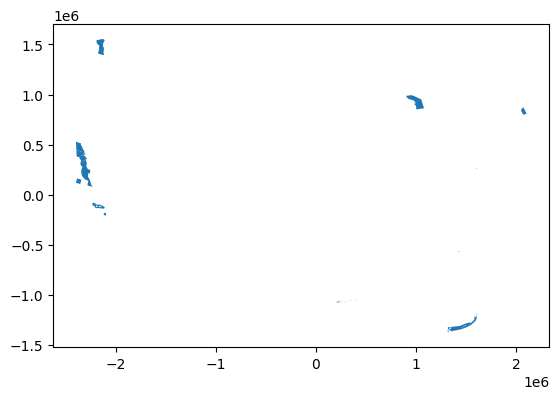

In [29]:
# read in marine sanctuaries shapefiles, combine, and project to our GRIDCERF projection
marine_sanctuary_files = [cordell_ms_shpfile, 
                          channel_islands_ms_shpfile,
                          flower_garden_ms_shpfile,
                          florida_keys_ms_shpfile,
                          greater_farallones_ms_shpfile,
                          grays_reef_ms_shpfile,
                          monterey_bay_ms_shpfile,
                          monitor_ms_shpfile,
                          mallows_bay_ms_shpfile,
                          olympic_coast_ms_shpfile,
                          stellwagen_bank_ms_shpfile,
                          thunder_bay_ms_shpfile]

ms_gdf = gpd.GeoDataFrame()
for file in marine_sanctuary_files:
    gdf = gpd.read_file(file).to_crs(crs)
    ms_gdf = gpd.GeoDataFrame(pd.concat([ms_gdf, gdf], ignore_index=True))

ms_gdf.plot()

In [32]:
# only keep marine sanctuaries within our GRIDCERF boundary
ms_gdf = gpd.clip(ms_gdf, bdf)

# add field to use for rasterization
ms_gdf["value"] = 1

In [48]:
# generate raster for marine sanctuaries
vector_to_raster(template_raster=template_raster, 
                 conus_mask=conus_mask,
                 gdf=ms_gdf, 
                 value_field="value",
                 output_raster=output_marine_sanctuaries_file)